# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

import time
from common_utils import EarlyStopper
from common_utils import split_dataset, preprocess_dataset
from statistics import mean

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    # YOUR CODE HERE
    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    # each list contains the accuracy/loss/time for each epoch 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper()
    loss_fn = nn.BCELoss()
    # Load data
    training_data = CustomDataset(X_train_scaled, y_train2)
    training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    validation_data = CustomDataset(X_val_scaled, y_val2)
    validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    no_epochs = 100
    for epoch in range(no_epochs):
        # Training
        start_time = time.time()
        train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
        for i, (x, y) in enumerate(training_dataloader):
            # Prediction
            y_pred = model(x) # shape: [256, 1]
            y_pred = y_pred.squeeze(dim=1) # to get shape [256]
            # Compute loss
            loss = loss_fn(y_pred.float(), y.float())
            train_loss += loss.item()
            # Compute accuracy
            # transform y_pred to give class 0 or class 1
            pred_label = [1 if i > 0.5 else 0 for i in y_pred]
            # compare pred_label with the ground truth y, add 1 to the train_acc variable if the prediction is correct
            train_acc += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_time = time.time() - start_time
        times.append(training_time)
        # To get mean training loss per batch, divide by number of batches in training
        no_train_batches = len(training_dataloader)
        train_losses.append(train_loss/ no_train_batches)
        # To get mean training accuracy per input, divide by number of training inputs
        no_train_inputs = len(training_dataloader.dataset) 
        train_accuracies.append(train_acc/ no_train_inputs)
        # Testing
        with torch.no_grad():
            for i, (x, y) in enumerate(validation_dataloader):
                # Prediction
                y_pred = model(x) # shape: [256, 1]
                y_pred = y_pred.squeeze(dim=1) # to get shape [256]
                # Compute loss
                loss = loss_fn(y_pred.float(), y.float())
                test_loss += loss.item()
                # Compute accuracy
                # transform y_pred to give class 0 or class 1
                pred_label = [1 if i > 0.5 else 0 for i in y_pred]
                # compare pred_label with the ground truth y, add 1 to the test_acc variable if the prediction is correct
                test_acc += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])
        # To get mean test loss per batch, divide by number of batches in testing
        no_test_batches = len(validation_dataloader)
        test_losses.append(test_loss/ no_test_batches)
        # To get mean test accuracy per input, divide by number of inputs in testing
        no_test_inputs = len(validation_dataloader.dataset)
        test_accuracies.append(test_acc/ no_test_inputs)
        if early_stopper.early_stop(test_loss):
            print("Early stopping at epoch number: ", epoch+1)
            break
    return train_accuracies, train_losses, test_accuracies, test_losses, times



In [4]:

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    if mode != "num_neurons":
        print("Please enter a valid mode")
        return
    cross_validation_accuracies_final_epoch, training_times = {}, {}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for parameter in parameters:
        for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
            # Scale the training set and validation set separately
            standard_scaler = preprocessing.StandardScaler()
            X_train_, X_val_ = X_train[train_index], X_train[val_index]
            # Only fit the scaler to training data, not to validation nor test data
            X_train_scaled = standard_scaler.fit_transform(X_train_) 
            X_val_scaled = standard_scaler.transform(X_val_)
            y_train2 = y_train[train_index]
            y_val2 = y_train[val_index]
        model = MLP(no_hidden=parameter, no_features=77, no_labels=1)
        train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
        cross_validation_accuracies_final_epoch[parameter] = test_accuracies[-1]
        training_times[parameter] = mean(times)

        print("Parameter: ", parameter)
        print("Mean cross-validation accuracy on last epoch: ", cross_validation_accuracies_final_epoch[parameter])
        print("Mean training time: ", training_times[parameter])
        
    return cross_validation_accuracies_final_epoch, training_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df_train, y_train, df_test, y_test = split_dataset(df, ['filename'], 0.3, 42)
X_train = df_train.drop(columns=["label"])

num_neurons = [64, 128, 256]
# use optimal batch size of 256 found in A2
optimal_bs = 256
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', batch_size=optimal_bs)

Early stopping at epoch number:  19
Parameter:  64
Mean cross-validation accuracy on last epoch:  0.6579727326615293
Mean training time:  0.24235665170769943
Early stopping at epoch number:  21
Parameter:  128
Mean cross-validation accuracy on last epoch:  0.6834617664493183
Mean training time:  0.4096165384565081
Early stopping at epoch number:  13
Parameter:  256
Mean cross-validation accuracy on last epoch:  0.6514522821576764
Mean training time:  0.36909107061532825


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

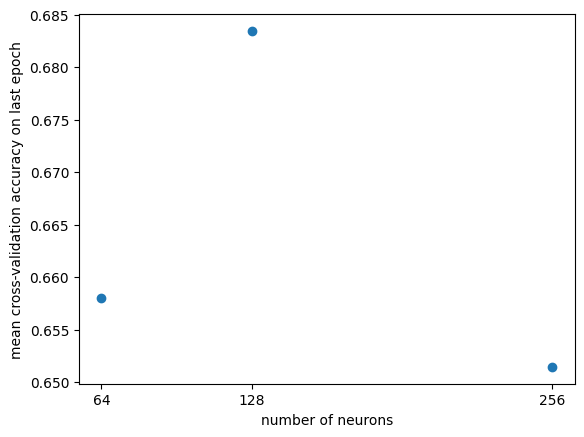

In [5]:
def acc_neuron(cross_validation_accuracies):
	plt.figure(1)
	plt.ylabel("mean cross-validation accuracy on last epoch")
	plt.xlabel("number of neurons")
	x = cross_validation_accuracies.keys()
	y = cross_validation_accuracies.values()
	plt.xticks(list(x))
	plt.scatter(x, y)
	plt.show()

acc_neuron(cross_validation_accuracies)

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [6]:
optimal_neurons = 128
reason = "Highest mean cross valiation accuracy. It takes the longest time to train (0.68 seconds per epoch), but the difference compared to the other two neuron numbers is very small at only 0.03seconds. Hence, accuracy takes the priority."


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

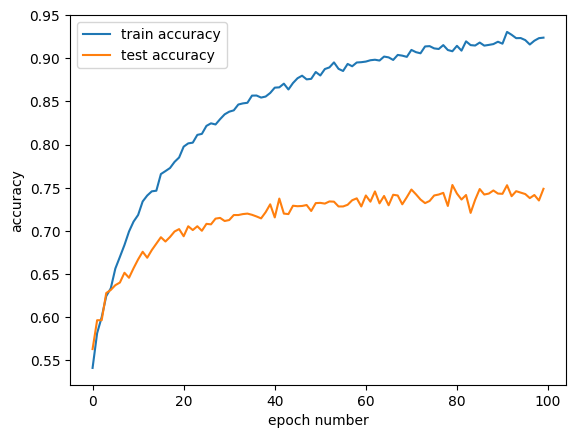

In [7]:
# YOUR CODE HERE
from common_utils import preprocess_dataset

def train_test(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=256):
	train_accuracies, test_accuracies = [], []
	# Use 128 neurons as found to be optimal above
	model = MLP(no_hidden=128, no_features=77, no_labels=1)
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
	loss_fn = nn.BCELoss()
	early_stopper = EarlyStopper()
	training_data = CustomDataset(X_train_scaled, y_train)
	training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
	test_data = CustomDataset(X_test_scaled, y_test)
	test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
	no_epochs = 100
	for epoch in range(no_epochs):
		train_acc, test_acc = 0, 0
		# Training
		for i, (x, y) in enumerate(training_dataloader):
			# Prediction
			y_pred = model(x) # shape: [256, 1]
			y_pred = y_pred.squeeze(dim=1) # to get shape [256]
			# Compute loss
			loss = loss_fn(y_pred.float(), y.float())
			# Compute accuracy
			# transform y_pred to give class 0 or class 1
			pred_label = [1 if i > 0.5 else 0 for i in y_pred]
			# compare pred_label with the ground truth y, add 1 to the train_acc variable if the prediction is correct
			train_acc += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])
			# Backpropagation
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
		# To get mean accuracy per train input, divide by the number of train inputs
		no_train_inputs = len(training_dataloader.dataset)
		train_accuracies.append(train_acc/ no_train_inputs)
		# Testing
		with torch.no_grad():
			for i, (x, y) in enumerate(test_dataloader):
				# Prediction
				y_pred = model(x) # shape: [256, 1]
				y_pred = y_pred.squeeze(dim=1) # to get shape [256]
				# Compute accuracy
				# transform y_pred to give class 0 or class 1
				pred_label = [1 if i > 0.5 else 0 for i in y_pred]
				# compare pred_label with the ground truth y, add 1 to the test_acc variable if the prediction is correct
				test_acc += sum([1 if i == j else 0 for i, j in zip(pred_label, y)])
		# To get mean accuracy per test input, divide by the number of test inputs
		no_test_inputs = len(test_dataloader.dataset)
		test_accuracies.append(test_acc/ no_test_inputs)
	return train_accuracies, test_accuracies

	
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df_train, y_train, df_test, y_test = split_dataset(df, ['filename'], 0.3, 42)
X_train = df_train.drop(columns=["label"])
X_test = df_test.drop(columns=["label"])
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Use optimal batch size of 256 as found in part A2
train_acc_list, test_acc_list = train_test(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=256)

def acc_epoch(train_acc_list, test_acc_list):
		plt.figure(1)
		plt.ylabel("accuracy")
		plt.xlabel("epoch number")
		plt.plot(range(len(train_acc_list)), train_acc_list, label="train accuracy")
		plt.plot(range(len(train_acc_list)), test_acc_list, label="test accuracy")
		plt.legend()
		plt.show()

acc_epoch(train_acc_list, test_acc_list)